---
---
# NEURAL NETWORKS AND DEEP LEARNING

### A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli

# Homework 1 - Supervised Deep Learning
---
---

## Regression task

In [1]:
#################
#### IMPORTS ####
#################

# Dataframes and Arrays
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


### Dataset and DataLoader 

In [2]:
class CsvDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        # Read the file and split the lines in a list
        self.data = pd.read_csv(csv_file)
        self.names = self.data.columns
        # Now self.data contains all our dataset.
        # Each element of the list self.data is a tuple: (input, output)

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample
    
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())
    

In [3]:
# DOWNLOADING THE DATA
data_url = "https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/"

# wget without showing the output, I already checked it works
!wget -P regression_dataset {data_url}train_data.csv &> /dev/null # download training set
!wget -P regression_dataset {data_url}test_data.csv  &> /dev/null # download test set


In [4]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('regression_dataset/train_data.csv', transform=composed_transform)
test_dataset  = CsvDataset('regression_dataset/test_data.csv', transform=composed_transform)

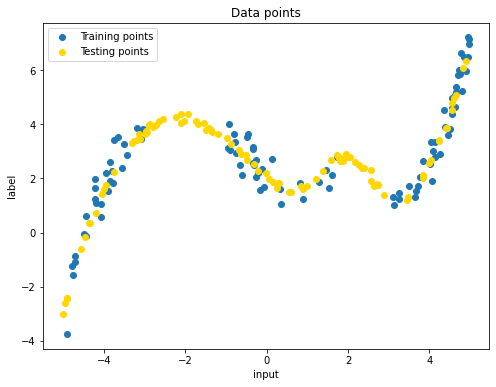

In [5]:
fig = plt.figure(figsize=(8,6))
# Plotting training and test points
plt.scatter(train_dataset.data.input, train_dataset.data.label, label='Training points')
plt.scatter(test_dataset.data.input, test_dataset.data.label, label='Testing points', color='gold')

plt.title('Data points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

### Building the Neural Network Structure

In [6]:
class Net(nn.Module):
    def __init__(self, Ni, No, Nhs):
        """
        Ni - Input size  (INT)
        No - Output size (INT)
        Nhs - Hidden layers (LIST OF INTEGERS)
        """
        super().__init__()
        nhidden = len(Nhs) # number of hidden layers
        # Creating an array of layers
        Ns = [Ni] + Nhs + [No]
        # First layer
        self.fc1 = nn.Linear(in_features=Ns[0], out_features=Ns[1])
        
        # Hidden layers
        self.hidden = nn.ModuleList()
        for h in range(nhidden-1):
            self.hidden.append(nn.Linear(in_features=Ns[h+1], out_features=Ns[h+2]))
            
        # Last layer
        self.out = nn.Linear(in_features=Ns[-2], out_features=Ns[-1])
        
        self.act = nn.Sigmoid()
    
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        
        for h in range(len(self.hidden)):
            x = self.act(self.hidden[h](x))
        
        x = self.out(x)
        return x

In [7]:
# Quick test for the NN structure
net = Net(1,1,[3,3,4])
print(net)

Net(
  (fc1): Linear(in_features=1, out_features=3, bias=True)
  (hidden): ModuleList(
    (0): Linear(in_features=3, out_features=3, bias=True)
    (1): Linear(in_features=3, out_features=4, bias=True)
  )
  (out): Linear(in_features=4, out_features=1, bias=True)
  (act): Sigmoid()
)
